# 딥러닝 팀 프로젝트 최종 발표



*   산업정보시스템전공 김지환 19620021
*   박찬교

# 1. 팀프로젝트 작업환경 구성

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import misc
import imageio as im
import os, sys
import warnings
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
import seaborn as sns 
sns.set()
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# path configuration
import zipfile, os, shutil

dataset = '/content/gdrive/My Drive/datasets/sampleD.zip'
dst_path = '/content/gdrive/My Drive/datasets/sampleD'
dst_file = os.path.join(dst_path, 'sampleD_subset.zip')

# directory makedir
if not os.path.exists(dst_path):
    os.makedirs(dst_path)
    print('make directory')

In [4]:
# copy zip file
#shutil.copy(dataset, dst_file)

# unzip
#with zipfile.ZipFile(dst_file, 'r') as file:
#  file.extractall(dst_path)

In [5]:
# path check
path = dst_path
os.chdir(path)
os.getcwd()

'/content/gdrive/My Drive/datasets/sampleD'

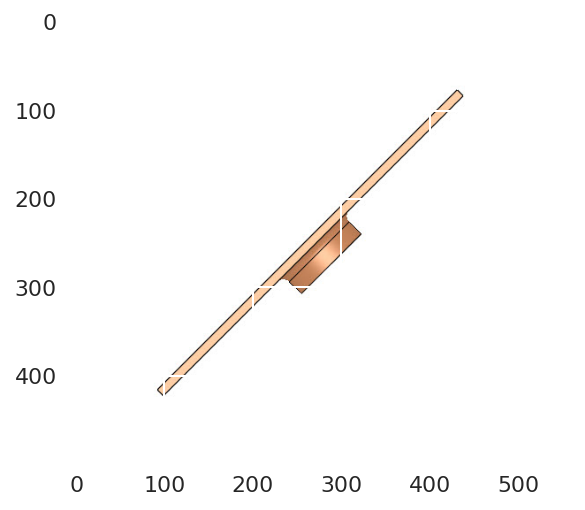

In [6]:
# image unzip check
img = im.imread('/content/gdrive/My Drive/datasets/sampleD/burring_(12).jpg')
plt.imshow(img, cmap='gray')

# 2. 데이터 전처리

**2.1. 데이터 클래스 분류**

In [7]:
# define constant variable
FAST_RUN = False
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

**2.2. 이미지 raw 파일에서 카테고리(클래스) 추출 및 데이터프레임 구성**

In [8]:
# raw 데이터에서 카테고리(클래스)를 분류해서 데이터 프레임에 (파일명, 카테고리) 배열로 저장.
filenames = os.listdir('/content/gdrive/My Drive/datasets/sampleD/')
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'burring':
        categories.append(1)
    elif category == 'forming':
        categories.append(2)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

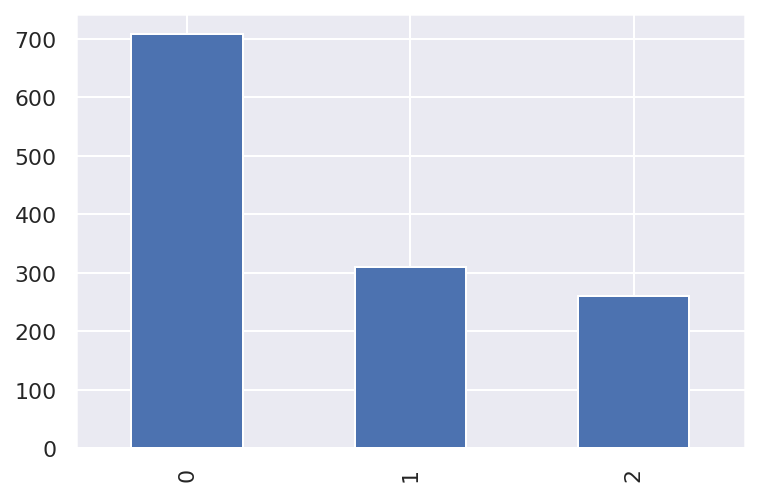

In [9]:
df['category'].value_counts().plot.bar()

In [10]:
df["category"] = df["category"].replace({0: 'bending', 1: 'burring', 2: 'forming'}) 

**2.3. 검증 데이터 Split**

In [11]:
# 훈련데이터 중 일부(20%)를 검증데이터로 사용하기 위해 split
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

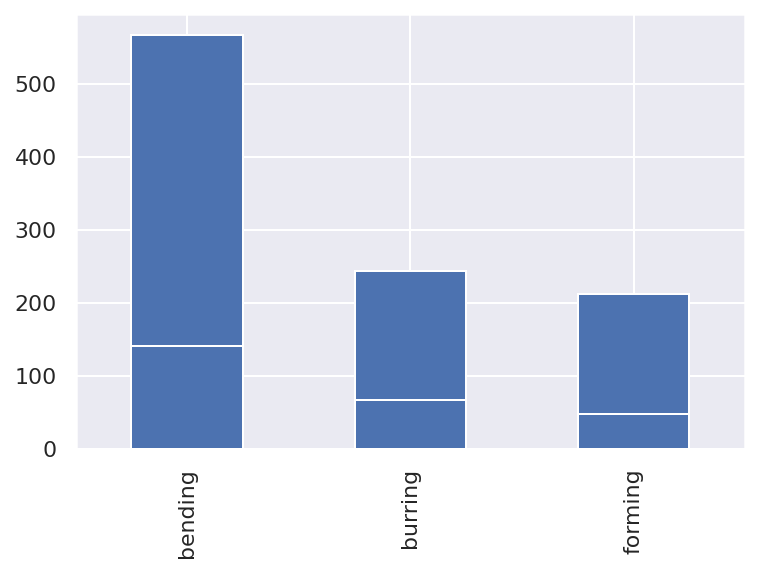

In [12]:
train_df['category'].value_counts().plot.bar()
validate_df['category'].value_counts().plot.bar()

In [13]:
# 배치 사이즈 설정 및 훈련/검증 데이터 shape
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=50

**2.4. 이미지 제너레이션(훈련데이터/검증데이터)**

In [14]:
# 이미지를 학습하기 위해 훈련데이터 이미지를 제너레이션 함
from keras.preprocessing.image import ImageDataGenerator, load_img

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    '/content/gdrive/My Drive/datasets/sampleD/', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Using TensorFlow backend.


Found 1015 validated image filenames belonging to 3 classes.


In [15]:
# 이미지를 학습하기 위해 검증데이터 이미지를 제너레이션 함
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    '/content/gdrive/My Drive/datasets/sampleD/', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 251 validated image filenames belonging to 3 classes.


In [16]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    '/content/gdrive/My Drive/datasets/sampleD/',  
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


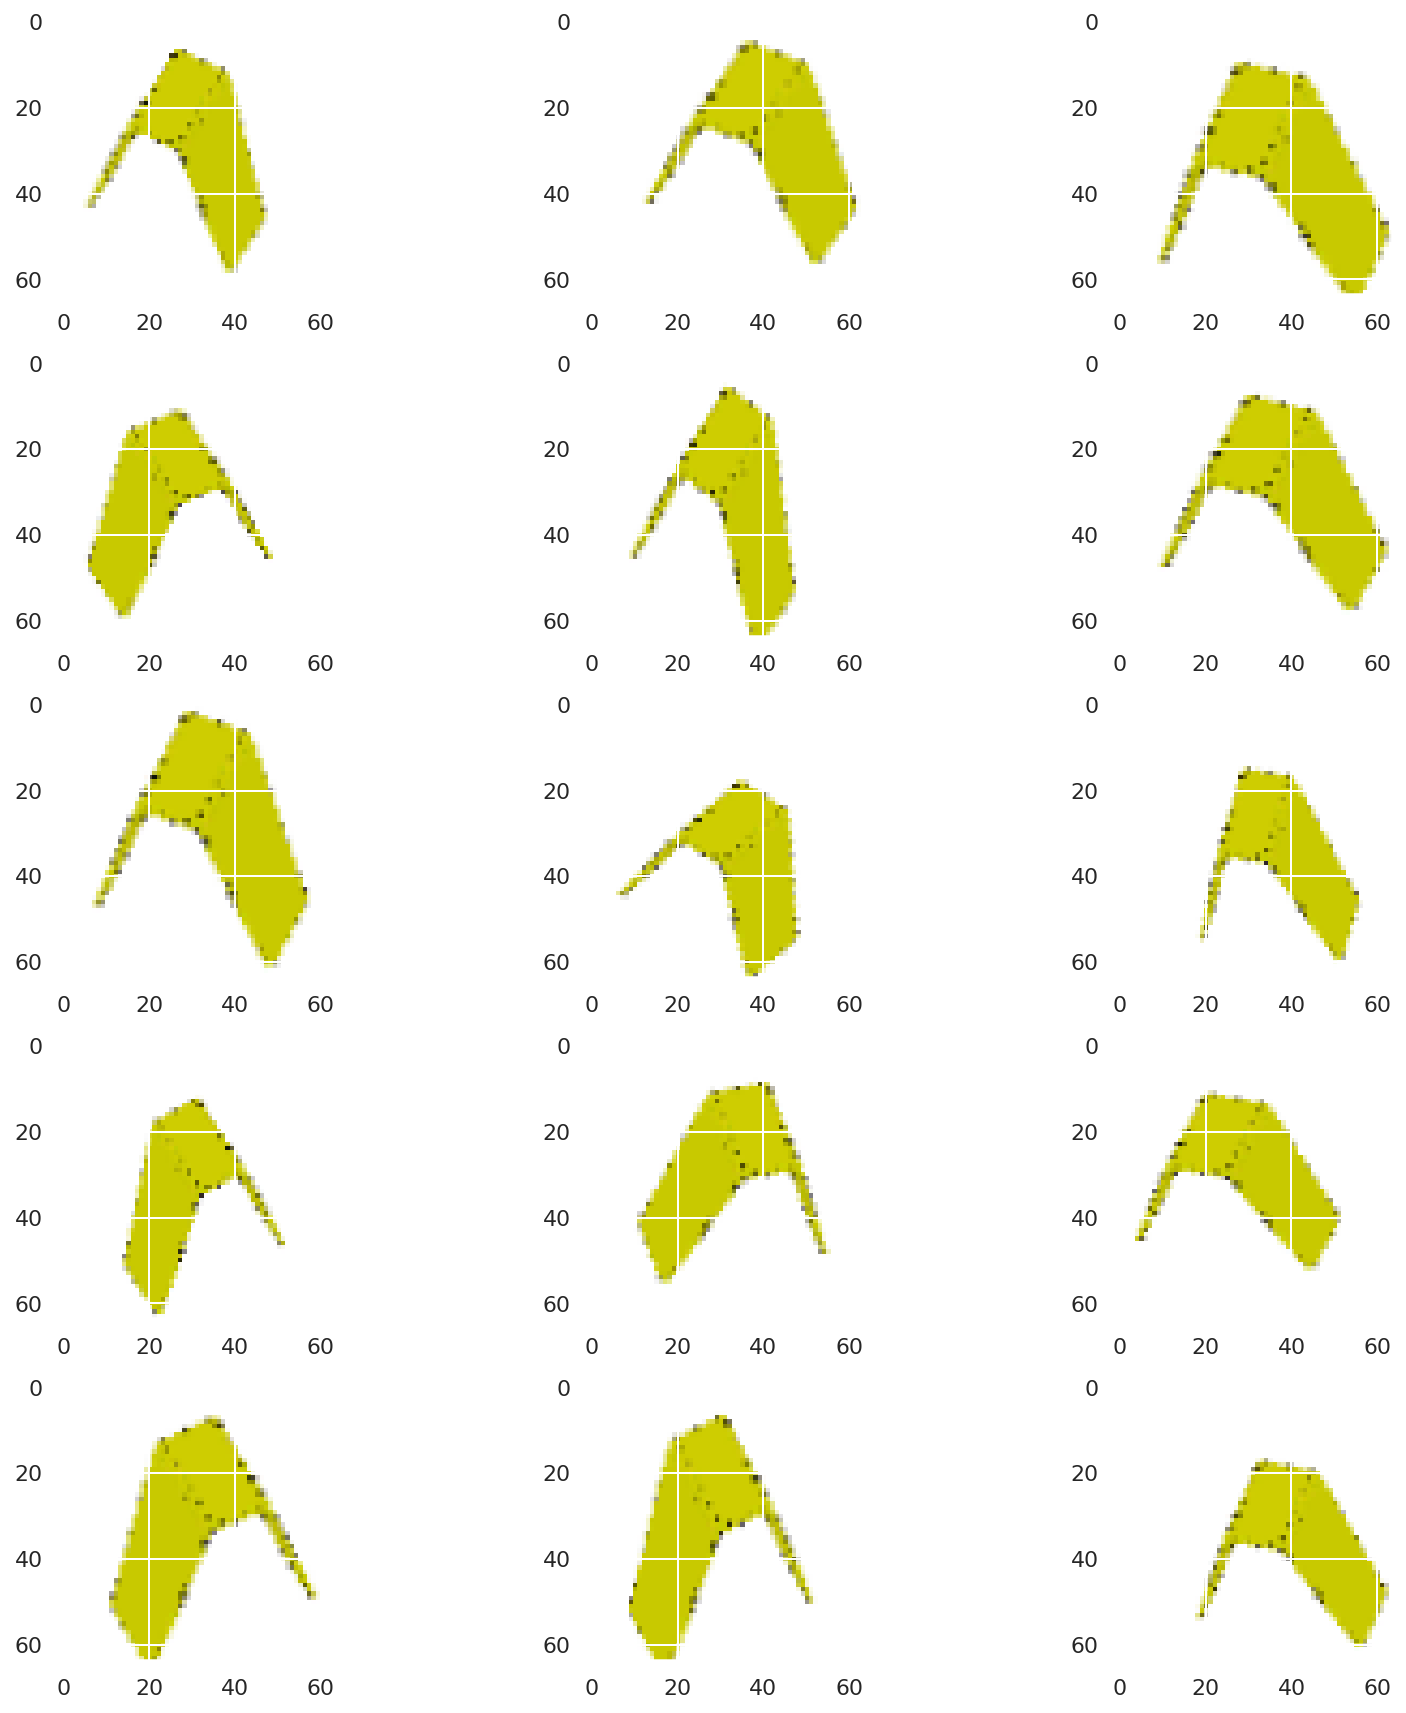

In [17]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# 3. 레이어(신경망) 구성

In [18]:
# 레이어(신경망) 구성 - 4 layer
# 손실함수: categorical_crossentropy 사용.
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax')) # 3 class

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)       

In [19]:
# 모델의 정확도가 향상되지 않는 경우 - 이슈 1.
# learning rate (lr) 을 줄여주는 클래스(ReduceLROnPlateau) 이용

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

# 4. 모델 학습

In [20]:
# 학습 시작
# 학습에 걸린 시간 저장.

import time
start = time.time()  # 시작 시간 저장

epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/50
20/20 [==============================] - 339s 17s/step - loss: 1.0021 - accuracy: 0.6788 - val_loss: 1.3051 - val_accuracy: 0.2680
Epoch 2/50
20/20 [==============================] - 32s 2s/step - loss: 0.7248 - accuracy: 0.7503 - val_loss: 1.3454 - val_accuracy: 0.5473
Epoch 3/50
20/20 [==============================] - 18s 875ms/step - loss: 0.6494 - accuracy: 0.7679 - val_loss: 1.6749 - val_accuracy: 0.5373
Epoch 4/50
20/20 [==============================] - 17s 860ms/step - loss: 0.5698 - accuracy: 0.7886 - val_loss: 2.7015 - val_accuracy: 0.5473

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
20/20 [==============================] - 17s 845ms/step - loss: 0.4977 - accuracy: 0.7959 - val_loss: 2.3095 - val_accuracy: 0.5622
Epoch 6/50
20/20 [==============================] - 17s 828ms/step - loss: 0.4349 - accuracy: 0.8560 - val_loss: 9.1129 - val_accuracy: 0.5174
Epoch 7/50
20/20 [==============================] - 18s 890ms/ste

In [21]:
model.save_weights("model_final_s8.h5")

In [22]:
import numpy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

print("훈련 정확도:: " , numpy.mean(acc))
print("검증 정확도:: " ,numpy.mean(val_acc))

훈련 정확도::  0.8185556
검증 정확도::  0.5162406184456565


# 5. 예측
**5.1. 테스트(예측) 데이터 준비**

In [23]:
# 테스트 데이터 load
test_filenames = os.listdir('/content/gdrive/My Drive/datasets/sampleD/test')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

**5.2. 이미지 제너레이션(예측(테스트) 데이터)**

In [24]:
# 테스트 데이터 제너레이션.
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    '/content/gdrive/My Drive/datasets/sampleD/test',
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 208 validated image filenames.


**5.3. 학습한 모델에 테스트 데이터로 예측**

In [25]:
# 테스트 데이터를 위에서 학습하여 나온 모델 사용하기 - 예측(predict)
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

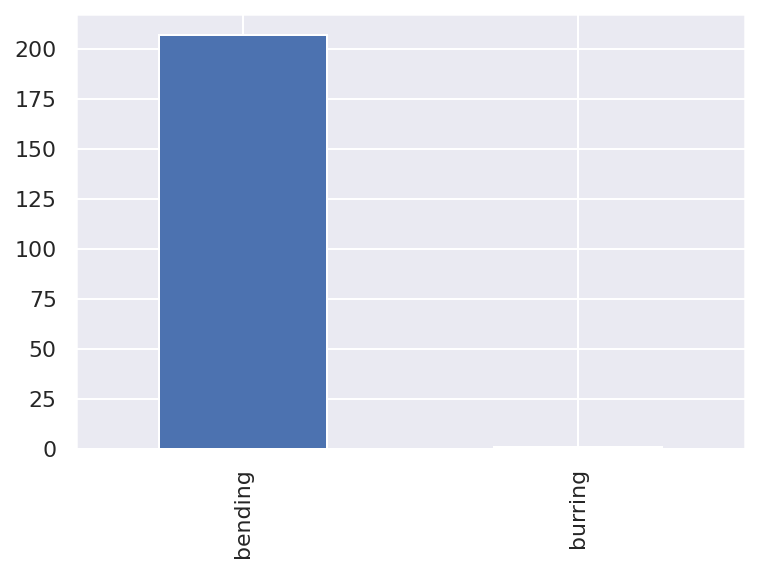

In [26]:
# 테스트 데이터 카테고리별 통계 시각화
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({0: 'bending', 1: 'burring', 2: 'forming'})
test_df['category'].value_counts().plot.bar()

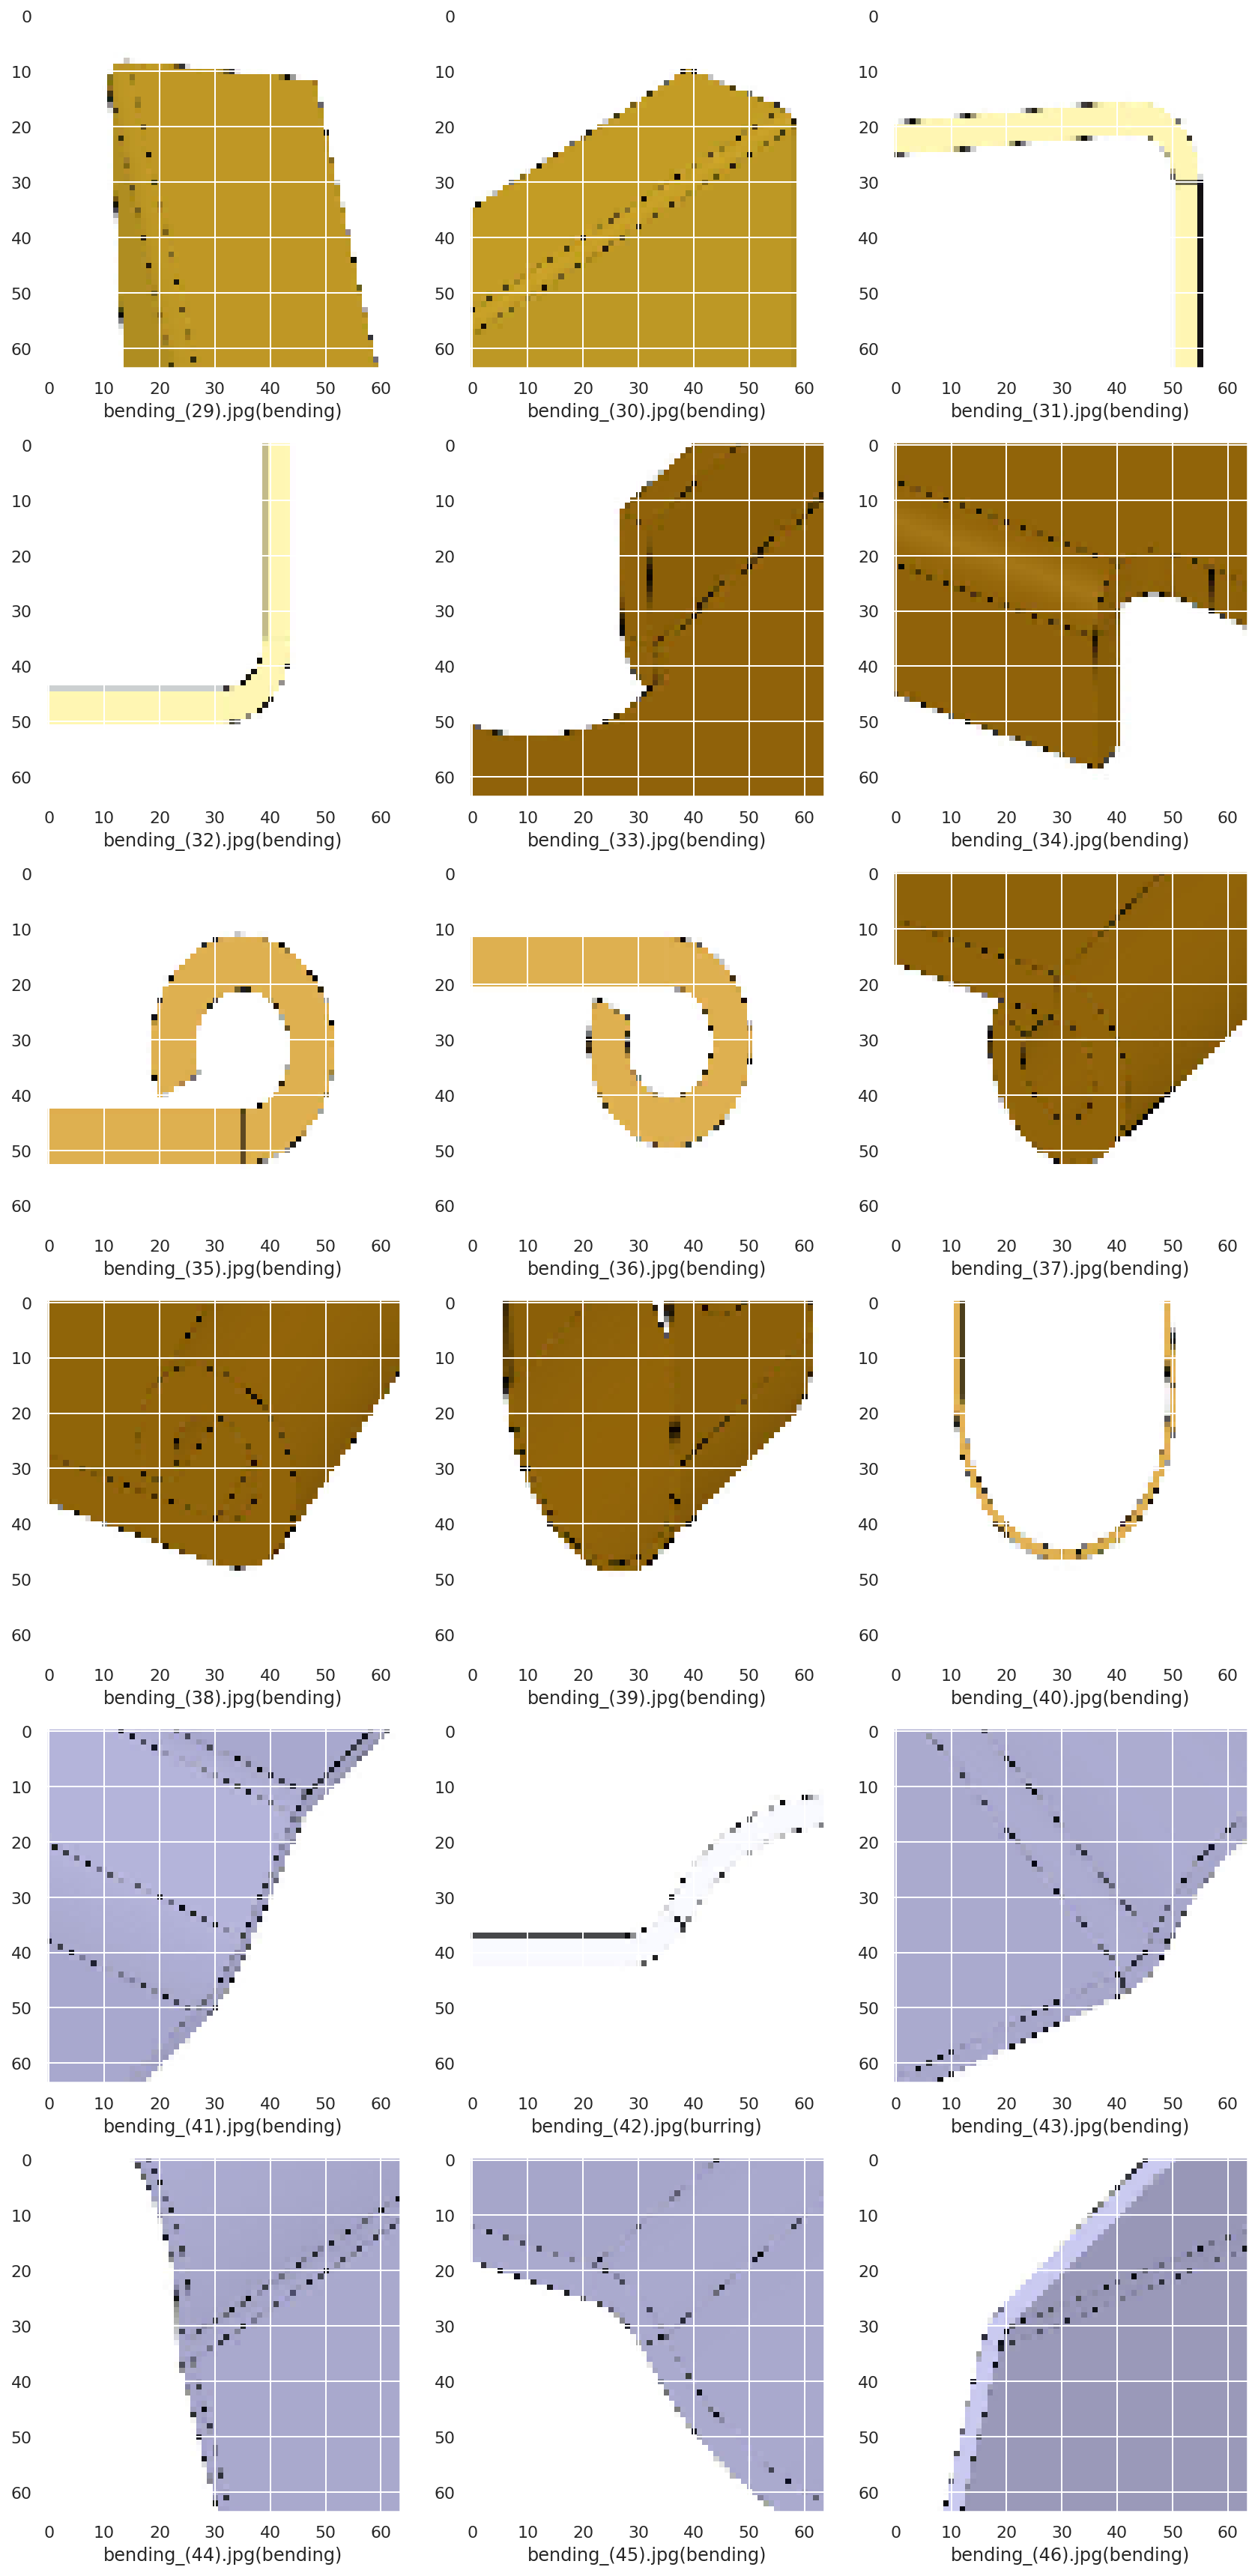

In [27]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('/content/gdrive/My Drive/datasets/sampleD/test/'+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# 6. 결과 분석
**6.1. 학습모델(훈련/검증) 정확도, 손실 시각화**

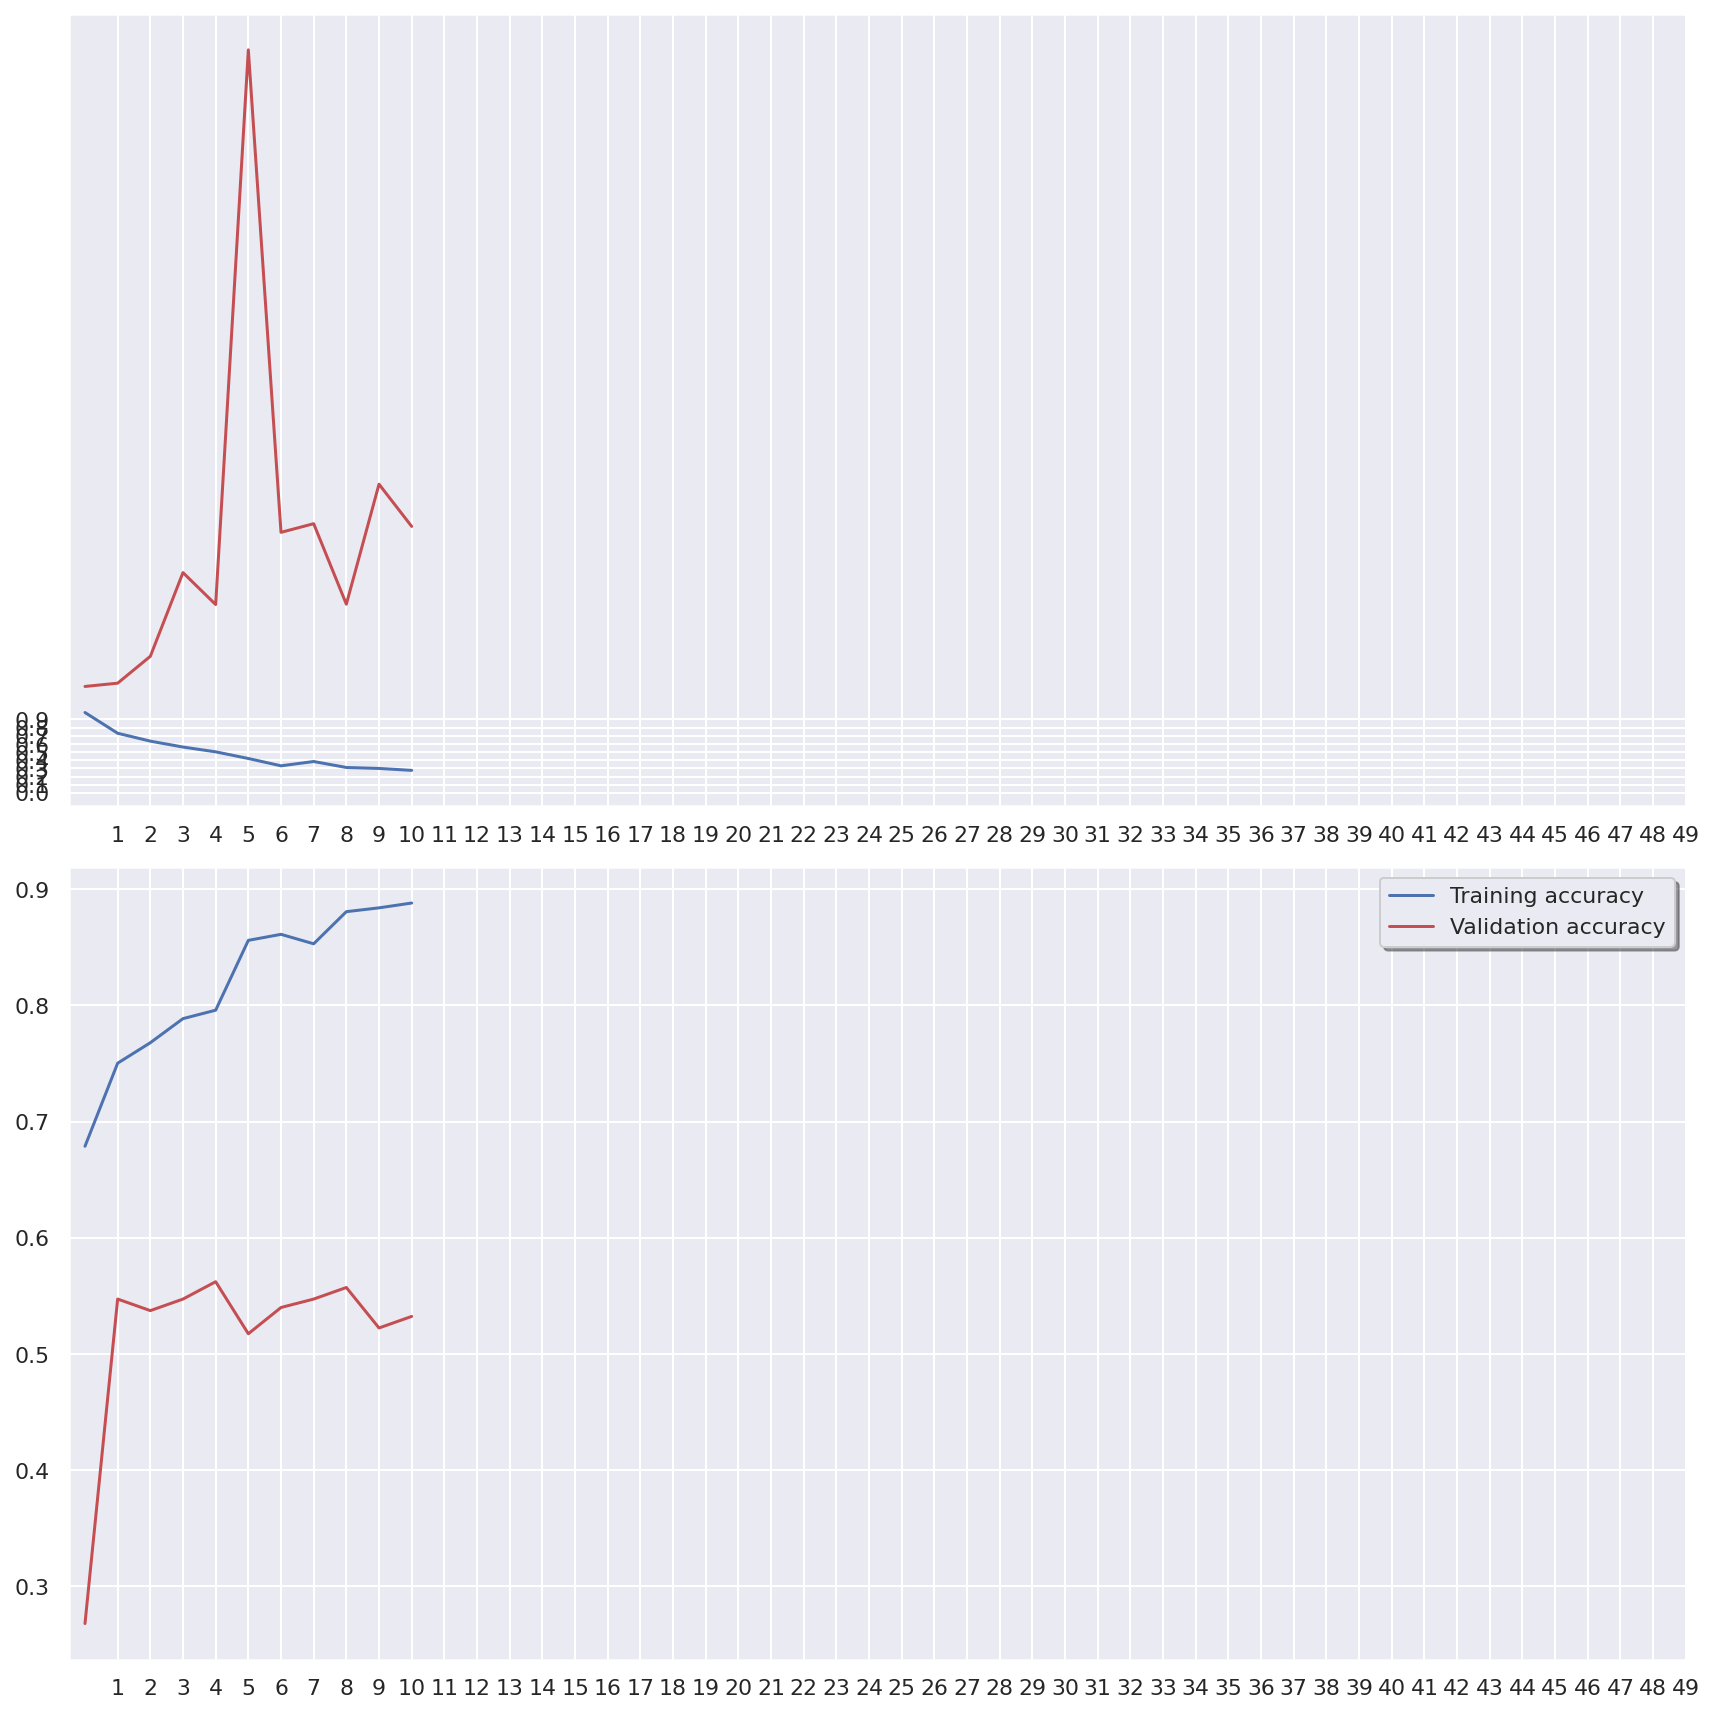

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

**6.2. 예측 결과값 scv 파일로 저장**

In [29]:
# 예측 결과를 csv 파일로 추출.
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_final_s8.csv', index=False)